# Learning Algorithms

> Inspired by [Sam Lau](https://www.samlau.me/), who co-authored the [Learning Data Science](https://learningds.org/ch/12/pa_intro.html) book.

In this lesson, we'll introduce machine learning from the ground up. By the end of this lesson, students will be able to:

- Describe the difference between traditional algorithms and machine learning algorithms.
- Identify the components of a machine learning model and dataset features and labels.
- Apply `sklearn` to train a decision tree for classification and regression tasks.

A while back, we discussed data visualization using the [Puget Sound Clean Air Agency's](https://pscleanair.gov/) EPA-grade air quality sensors (**AQS**). However, these sensors are typically expensive, costing anywhere between \\$15,000 and \\$40,000 each, making it hard to deploy a large number of these sensors. Furthermore, EPA-grade AQS measurements also undergo calibration and accuracy checks that lead to delays of one or two hours, leading to data that is very accurate but not necessarily timely.

In contrast, "[PurpleAir](https://www2.purpleair.com/) makes sensors that empower Community Scientists who collect hyper-local air quality data and share it with the public." In this lesson, we'll learn how we can use more accurate but less timely AQS measurements to calibrate the less accurate but more timely PurpleAir sensor (**PAS**) measurements so that we can provide the best information to the general public. The concepts in this lesson are actually used in the real world when you visit the EPA [AirNow Fire and Smoke Map](https://fire.airnow.gov/): the PAS data in this map are calibrated using the approach we will learn today.

In [114]:
import pandas as pd
import seaborn as sns

sns.set_theme()

Our dataset includes over 12,000 matched observations where we've paired each AQS measurement with a nearby PAS measurement, along with 3 other variables that experts have identified as potentially impacting PAS measurement quality. The dataset includes 5 columns:

- The very accurate EPA-grade air quality sensor (AQS) measurement of the PM2.5 value.
- The temperature in degrees celsius.
- The relative humidity as a percentage between 0% and 100%.
- The dew point, where a higher dew point means more moisture in the air.
- The less accurate but more timely PurpleAir sensor (PAS) measurement of the PM2.5 value.

**How can we use the PAS measurement together with the temperature, humidity, and dew point to predict the AQS measurement?**

In [115]:
sensor_data = pd.read_csv("sensor_data.csv")
sensor_data

,AQS,temp,humidity,dew,PAS
0,6.7,18.027263,38.564815,3.629662,8.616954
1,3.8,16.115280,49.404315,5.442318,3.493916
2,4.0,19.897634,29.972222,1.734051,3.799601
3,4.7,21.378334,32.474513,4.165624,4.369691
4,3.2,18.443822,43.898226,5.867611,3.191071
...,...,...,...,...,...
12092,5.5,-12.101337,54.188889,-19.555834,2.386120
12093,16.8,4.159967,56.256030,-3.870659,32.444987
12094,15.6,1.707895,65.779221,-4.083768,25.297018
12095,14.0,-14.380144,48.206481,-23.015378,8.213208


Let's use data visualization to understand this dataset by scatter-plotting PAS to AQS. (Why do we place PAS on the x-axis and AQS on the y-axis?)

c:\Users\2022093\.conda\envs\environment\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


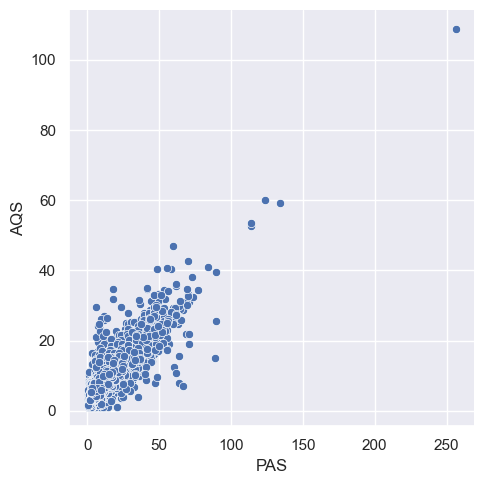

In [116]:
sns.relplot(sensor_data, x="PAS", y="AQS")

## Guessing game

Let's start with a simpler task: **How can we use the PAS measurement alone to predict the AQS measurement?** To do this, let's choose a line that best describes the trend, or the regression line that is produced by calling `lmplot`.

c:\Users\2022093\.conda\envs\environment\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


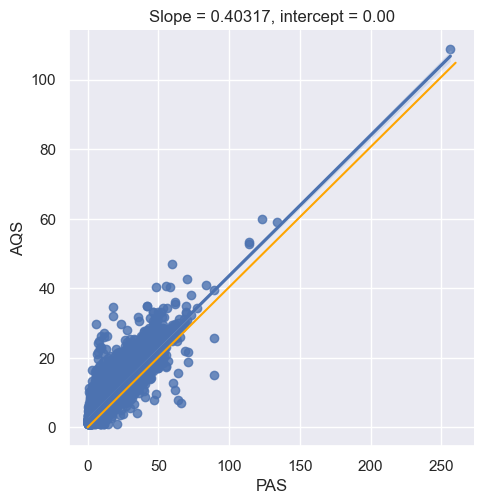

In [117]:
def plot_line(slope, intercept=0):
    grid = sns.lmplot(sensor_data, x="PAS", y="AQS")
    grid.facet_axis(0, 0).plot([0, 260], [intercept, slope * 260 + intercept], c="orange")
    grid.set(title=f"Slope = {slope:.5f}, intercept = {intercept:.2f}")
    return grid


plot_line(0.403167)

What differentiates *machine learning* from just human guessing is the use of an algorithm to find the best line, which requires a **metric** for the quality of a trend.

We can visualize all of our guesses so far by plotting them against their mean squared errors on what's called a **loss surface**.

In [ ]:
import numpy as np
def plot_loss(slopes):
    losses = []
    x = sensor_data["PAS"]
    y = sensor_data["AQS"]
    for s in slopes:
        y_pred = s*x
        mse = np.mean((y-y_pred)**2)
        losses.append(mse)
    grid = sns.relplot(x=slopes, y = losses)
    grid.set(title="Loss surfaces", xlabel = "Slope", ylabel = "MSE")
    return grid
# def plot_loss(slopes):
#     losses = [... for s in slopes]
#     grid = sns.relplot(x=slopes, y=losses)
#     grid.set(title="Loss surface", xlabel="Slope", ylabel="MSE", xlim=[0, 1], ylim=[0, None])
#     return grid


plot_loss([...])

## Gradient descent

So how do we write a **machine learning algorithm** that can optimize this metric and find the minimum mean squared error in the loss surface so that it selects the best possible line? Machine learning scientists can apply concepts from linear algebra to solve this system by selecting a random initial theta (slope) value and then rolling down the hill toward the minimum value at the bottom of the bowl. We can express this using `numpy`, a numeric computation module for Python that is a building block for `pandas` and `sklearn` (as we'll see later).

$$
\nabla_{\!\theta}\; \text{MSE}(\boldsymbol{\theta}, \mathbf{X}, \mathbf{y}) = -\frac{2}{n}(\mathbf{X}^\top \mathbf{y} - \mathbf{X}^\top \mathbf{X} \boldsymbol{\theta})
$$

In [119]:
import numpy as np


def grad_mse(theta, X, y):
    return np.array(- 2 / len(X) * (X.T @ y - X.T @ X * theta))


thetas = [np.random.random()]
print("Random initial theta value:", thetas[-1])

Random initial theta value: 0.49389683022129727


We can then take a small step in the opposite direction of the gradient to roll down the hill until we converge on a good guess. To make this a machine learning algorithm, we simply put the update step in a loop until the theta values no longer noticeably change.

c:\Users\2022093\.conda\envs\environment\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\2022093\.conda\envs\environment\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


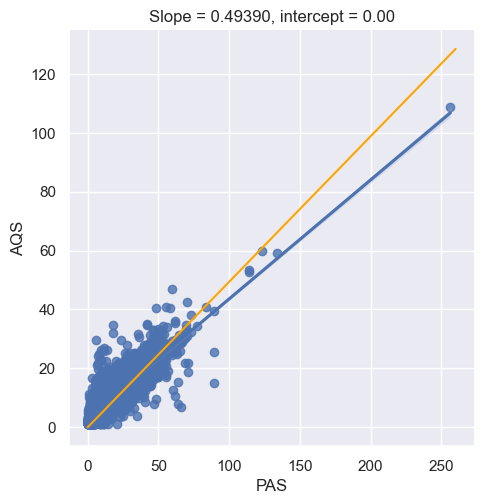

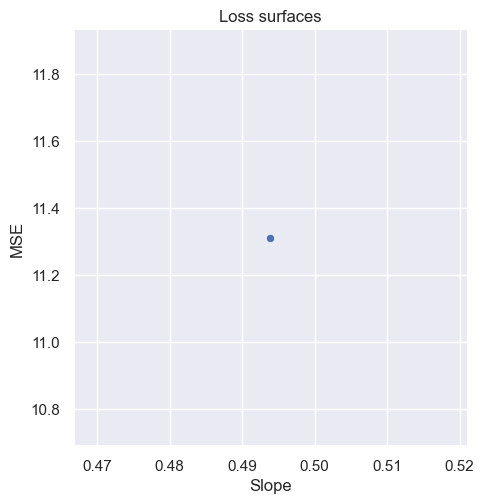

In [120]:
plot_line(thetas[-1])
plot_loss(thetas)

# Take a small step in the opposite direction of the gradient to roll downhill
thetas.append(thetas[-1] - 0.002 * grad_mse(thetas[-1], sensor_data["PAS"], sensor_data["AQS"]))

## Linear regression models

What we've just described is the gradient descent algorithm for fitting a linear regression model. A **linear regression model** is a machine learning model that is used to predict a numeric value (like AQS measurements) using a linear combination of coefficients and **features** (columns from the training dataset). scikit-learn provides an easy way to do define a linear regression model, fit our training dataset `X` to the target values `y`, and examine the coefficients to look inside the model.

In [121]:
from sklearn.linear_model import LinearRegression
X = sensor_data[["PAS"]]
y = sensor_data["AQS"]
reg = LinearRegression().fit(X, y)

print("Model:", " + ".join([f"{reg.intercept_:.2f}"] + [f"{coef:.2f}({X.columns[i]})" for i, coef in enumerate(reg.coef_)]))
print("Error:", mean_squared_error(y, reg.predict(X)))
plot_line(reg.coef_[0], reg.intercept_)

Model: 3.18 + 0.40(PAS)


NameError: name 'mean_squared_error' is not defined

This procedure is more or less how `lmplot` works!

In [ ]:
sns.lmplot(sensor_data, x="PAS", y="AQS")

But the advantage of designing our own model is that we can combine other variables to reduce the mean squared error loss. The final model that the EPA uses only takes into account the sensor measurement and the relative `humidity`, but not any other variables. Later, we'll learn why they made this decision.

## Classification versus regression

Everything we've seen so far fall under the category of **regression**, where we aim to predict a *numeric* target value (one column) from one or more features (one or more other columns). The other main category of problems is **classification**, which is just like regression except we aim to predict a *categorical* target value. For example, we might want to answer the question: **How can we predict whether a house belongs in `NY` or `SF` from its beds, baths, price, year of construction, square footage, price per square foot, and elevation?**

In [ ]:
homes = pd.read_csv("homes.csv")
homes

Let's learn about **decision trees**, a machine learning algorithm that can be used for classification (and also, as it turns out, regression too). Decision trees learn a nested if-then-else logical hierarchy to fit a training dataset. In the following visualization, the color and opacity of each box represents whether that subset of homes is more likely to be in `NY` or `SF`. The notes inside each node indicate information about the values:

1. The first line shows the condition. If the condition is true, go left; if not, go right.
1. The second line shows the percentage of samples represented by that node.
1. The third line shows the proportion of homes within that sample that belong in `["NY", "SF"]`.
1. The fourth line shows the majority class in that category, corresponding to the bigger number on line 3.

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
X = homes.drop("city", axis=1)
y = homes["city"]
clf = DecisionTreeClassifier(max_depth=2).fit(X, y)

import matplotlib.pyplot as plt
plt.figure(dpi=300)
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=["NY", "SF"],
    label="root",
    filled=True,
    impurity=False,
    proportion=True,
    rounded=False
);

We can also use this dataset for regression too. Write a one-line expression to train a `DecisionTreeRegressor` model to predict the price of a home in this dataset from all other variables.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg = ...
reg

Consider each of the following tasks and answer whether they would be best modeled as classification or regression.

<details>
<summary>Predict whether an email is spam or not spam.</summary>

Classification, since the target value is the category "spam" or "not spam".
</details>

<details>
<summary>Predict the number of views a video will receive based on subscriber count.</summary>

Regression, since the target value is a number.
</details>

<details>
<summary>Predict the next word to appear in a sentence.</summary>

Classification, since the target value is to choose from the dictionary of all possible next words.
</details>

> If you're curious about how ChatGPT works, Jay Mody has a good introduction to [GPT in 60 Lines of NumPy](https://jaykmody.com/blog/gpt-from-scratch/).